<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP3] - 12h predictions
<!-- DESC --> Episode 3: Attempt to predict in the longer term 
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Prediction at 12:00
 - Understand the principle of using reccurent neurons... and the limitations of our example !


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read the data
 - Make a reccurent prediction

## Step 1 - Import and init
### 1.1 - Python

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.5.0
Run time             : Sunday 1 March 2020, 20:18:54
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf


### 1.2 - Where are we ? 

In [2]:
place, dataset_dir = ooo.good_place( { 'GRICAD' : f'{os.getenv("SCRATCH_DIR","")}/PROJECTS/pr-fidle/datasets/SYNOP',
                                       'IDRIS'  : f'{os.getenv("WORK","")}/datasets/SYNOP',
                                       'HOME'   : f'{os.getenv("HOME","")}/datasets/SYNOP'} )

Well, we should be at HOME !
We are going to use: /home/pjluc/datasets/SYNOP


## Step 2 - Read and prepare dataset
As before, in episode 2... ;-)

In [7]:
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
train_len        = 25000
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- Read dataset
df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]

# ---- Normalize, and convert to numpy array
mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = np.array( (dataset_train - mean) / std )
dataset_test  = np.array( (dataset_test  - mean) / std )

print('Dataset : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


Dataset :  (29165, 14)
Train dataset :  (25000, 12)
Test  dataset :  (4165, 12)


## Step 3 - Predict

### 3.1 - Load model

In [16]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 3.2 Make a 12h prediction

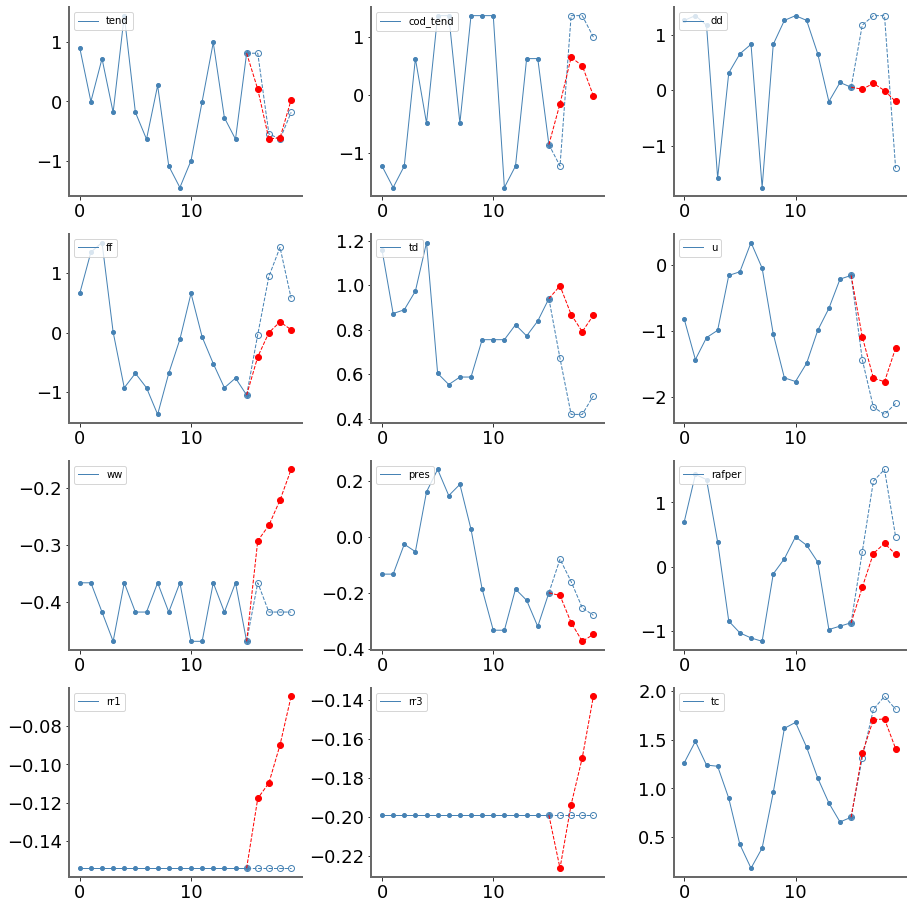

In [74]:
sequence_len = 16
iterations   = 4

# ---- Initial sequence

s=random.randint(0,len(dataset_test)-sequence_len-iterations)

sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

# ---- Iterate on 4 predictions

sequence_pred=list(sequence_pred)

for i in range(iterations):
    sequence=sequence_pred[-sequence_len:]
    pred = loaded_model.predict( np.array([sequence]) )
    sequence_pred.append(pred[0])

# ---- Extract the predictions    

pred=np.array(sequence_pred[-iterations:])
       
# ---- Show result

reload(ooo)
ooo.plot_multivariate_serie(sequence_true, predictions=pred, labels=features)


### 3.3 Full prediction
#### Some cool functions that do the job

In [77]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

#### And the result is...

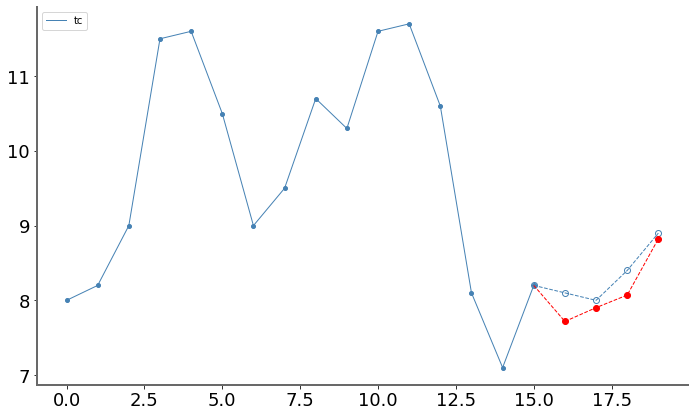

In [170]:
  
sequence_true, pred = get_prediction(dataset_test, loaded_model,iterations=4)

feat=11

reload(ooo)
ooo.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)

<div class="todo">
    What you can do:
    <ul>
        <li>Trying to increase the forecasting time</li>
        <li>What could we do to try to improve our forecasts?</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>